In [1]:
from io import StringIO
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver import ngeometry
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
superjunctions = '''
name	id	z_inv	h_0	bc	storage	a	b	c	max_depth	map_x	map_y
0	0	0	1	0.00001	False	functional	0.0	0.0	200.0	inf	0	0
1	1	1	0	0.25000	True	functional	0.0	0.0	100000000.0	inf	1	1
'''

superlinks = '''
	name	id	sj_0	sj_1	in_offset	out_offset	dx	n	shape	g1	g2	g3	g4	Q_0	h_0	ctrl	A_s	A_c	C	dx_uk	dx_dk	C_uk	C_dk
0	0	0	0	1	0.0	0.0	5000.0	0.035	rect_open	10	10	0	0	0	0.25	False	0.0	0	0	0.0	0.0	0.0	0.0
'''

In [3]:
superjunctions = pd.read_csv(StringIO(superjunctions), sep='\t')
superlinks = pd.read_csv(StringIO(superlinks), sep='\t')

# Instantiate and run model

In [4]:
Qs = {}
hs = {}
As = {}
Bs = {}

wavesizes = [1, 2, 5, 10, 20, 50]

for wavesize in wavesizes:
    internal_links = 50
    superlink = SuperLink(superlinks, superjunctions, internal_links=internal_links, mobile_elements=True)

    g1 = superlinks.loc[0, 'g1']
    g2 = superlinks.loc[0, 'g2']

    # Compute normal flow parameters for a given depth
    h = 0.25
    A = ngeometry.Rect_Open_A_ik(h, h, g1, g2)
    Pe = ngeometry.Rect_Open_Pe_ik(h, h, g1, g2)
    Q = (1 / superlink._n_ik) * (A**(5/3) / Pe**(2/3)) * np.sqrt(1 / superlink._dx_k)
    V = Q / A
    g = 9.81

    A = A * np.ones(len(Q))
    Pe = Pe * np.ones(len(Q))

    Fr = V / np.sqrt(g * h)

    # Set upstream inflow to normal flow
    Q_in_base = np.array([Q[-1], 0.])

    # Set downstream depth boundary condition to normal depth
    H_bc = np.array([0., h])

    # Set all internal states to normal flow
    superlink._h_Ik.fill(h)
    superlink._Q_ik.fill(Q[0])
    superlink._u_ik.fill(V[0])
    superlink._u_Ik.fill(V[0])
    superlink._u_Ip1k.fill(V[0])
    superlink._A_ik.fill(A[0])
    superlink._A_uk.fill(A[0])
    superlink._A_dk.fill(A[0])
    superlink._Q_uk.fill(Q[0])
    superlink._Q_dk.fill(Q[0])
    superlink.H_j.fill(h)
    superlink._V_sj = superlink._A_sj * h

    # Spin up model to stabilize
    superlink.spinup(n_steps=1000, dt=60, Q_in=Q_in_base, H_bc=H_bc)

    dt = 30
    t_span = 20 * 3600
    T = t_span // dt
    t_range = np.linspace(0, t_span, T)
    wave = wavesize * 1.0 * norm.pdf(np.linspace(-10, 10, T // 5))
    Q_in_t = np.zeros((T, 2))
    Q_in_t[:len(wave),0] = wave

    _h = []
    _Q = []
    _A = []
    _B = []
    t_ix = 0

    while superlink.t < t_span:
        Q_in = Q_in_base + Q_in_t[t_ix]
        superlink.step(dt=dt, Q_in=Q_in, num_iter=10, head_tol=1e-16)
        _h.append(superlink._h_Ik.copy())
        _Q.append(superlink._Q_ik.copy())
        _A.append(superlink._A_ik.copy())
        _B.append(superlink._B_ik.copy())
        t_ix += 1
    _h = np.vstack(_h)
    _Q = np.vstack(_Q)
    _A = np.vstack(_A)
    _B = np.vstack(_B)
    Qs[wavesize] = _Q.copy()
    hs[wavesize] = _h.copy()
    As[wavesize] = _A.copy()
    Bs[wavesize] = _B.copy()

In [5]:
hn = []
Qn = []
An = []

for h in np.linspace(0.25, 1.25):
    A = ngeometry.Rect_Open_A_ik(h, h, g1, g2)
    Pe = ngeometry.Rect_Open_Pe_ik(h, h, g1, g2)
    Q = ((1 / superlink._n_ik) * (A**(5/3) / Pe**(2/3)) * np.sqrt(1 / superlink._dx_k))[0]
    hn.append(h)
    Qn.append(Q)
    An.append(A)
    
hn = np.array(hn)
Qn = np.array(Qn)
An = np.array(An)

Text(0.5, 1.0, 'Gaussian flow input at upstream boundary')

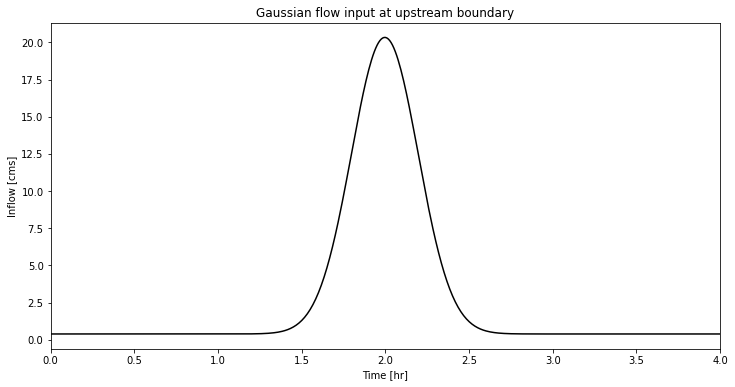

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_range / 3600, Q_in_base[0] + Q_in_t[:,0], c='k')
ax.set_xlabel('Time [hr]')
ax.set_ylabel('Inflow [cms]')
plt.xlim(0, 4)
plt.title('Gaussian flow input at upstream boundary')

In [7]:
# Position along channel to evaluate (1/2 along channel)
elem = internal_links // 2

(1.0, 5.0)

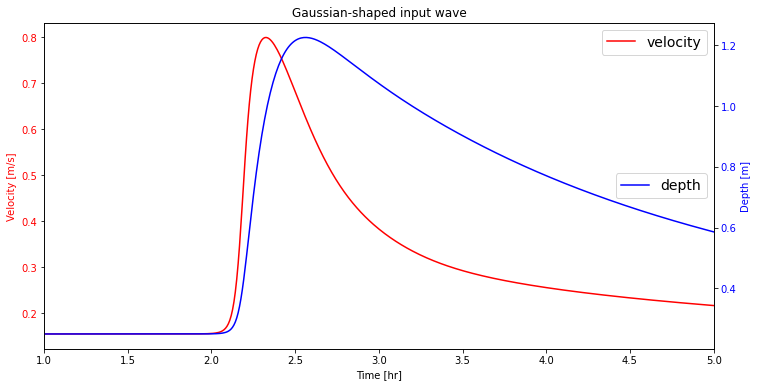

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t_range / 3600, _Q[:,elem] / _A[:,elem], c='r', label='velocity')
plt.legend(fontsize=14, loc='upper right')
#ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylabel('Velocity [m/s]', color='r')
ax1.set_xlabel('Time [hr]')

ax2 = ax1.twinx()
ax2.plot(t_range / 3600, _h[:,elem], c='b', label='depth')
plt.legend(loc='right', fontsize=14)
plt.xlim(0, 16)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Depth [m]', color='b')
plt.title('Gaussian-shaped input wave')

plt.xlim(1, 5)

Text(0.5, 1.0, 'Hydrographs at examination point')

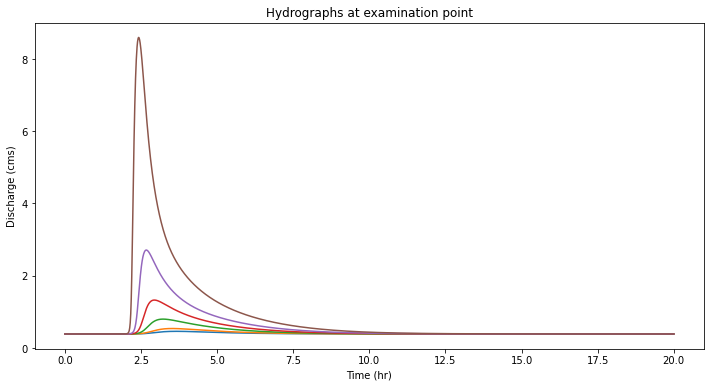

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in wavesizes:
    _Q = Qs[i]
    plt.plot(t_range / 3600, _Q[:,elem])
plt.xlabel('Time (hr)')
plt.ylabel('Discharge (cms)')
plt.title('Hydrographs at examination point')

Text(0, 0.5, 'Depth (m)')

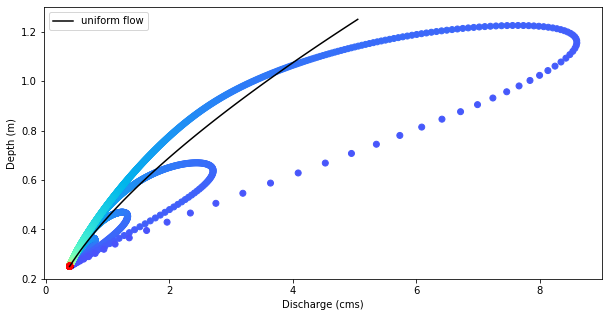

In [10]:
for i in wavesizes:
    _Q = Qs[i]
    _h = hs[i]
    plt.scatter(_Q[:,elem], _h[:,elem], c=t_range, cmap='rainbow')
plt.plot(Qn, hn, c='k', label='uniform flow')
plt.legend()
plt.xlabel('Discharge (cms)')
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

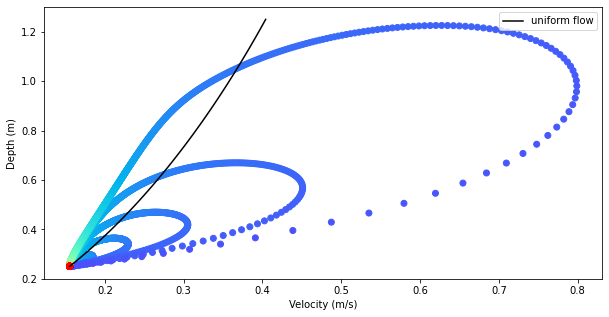

In [11]:
for i in wavesizes:
    _Q = Qs[i]
    _h = hs[i]
    _A = As[i]
    plt.scatter(_Q[:,elem] / _A[:,elem], _h[:,elem], c=t_range, cmap='rainbow')
plt.plot(Qn / An, hn, c='k', label='uniform flow')
plt.legend()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')

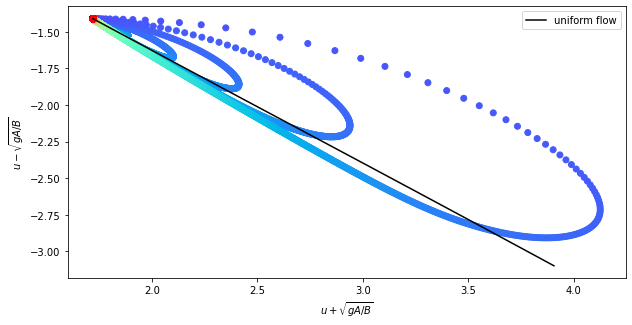

In [12]:
for i in wavesizes:
    _Q = Qs[i]
    _h = hs[i]
    _A = As[i]
    c1 = _Q[:,elem] / _A[:,elem] + np.sqrt(g * _A[:,elem] / _B[:,elem])
    c2 = _Q[:,elem] / _A[:,elem] - np.sqrt(g * _A[:,elem] / _B[:,elem])
    plt.scatter(c1, c2, c=t_range, cmap='rainbow')
c1n = Qn / An + np.sqrt(g * An / g2)
c2n = Qn / An - np.sqrt(g * An / g2)
plt.plot(c1n, c2n, c='k', label='uniform flow')
plt.xlabel('$u + \sqrt{g A / B}$')
plt.ylabel(r'$u - \sqrt{g A / B}$')
plt.legend()